In [2]:
from __future__ import division

import os
import numpy as np
import scipy.sparse
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.reset_defaults()

from scipy.io import loadmat
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from sklearn.utils.extmath import squared_norm
from sklearn.covariance import empirical_covariance
from importlib import reload
from regain import model_selection; reload(model_selection)
import regain
from regain.covariance import latent_time_graphical_lasso_; reload(latent_time_graphical_lasso_)
from regain.utils import error_norm

In [3]:
import collections

In [4]:
dir(collections.abc)

['AsyncGenerator',
 'AsyncIterable',
 'AsyncIterator',
 'Awaitable',
 'ByteString',
 'Callable',
 'Collection',
 'Container',
 'Coroutine',
 'Generator',
 'Hashable',
 'ItemsView',
 'Iterable',
 'Iterator',
 'KeysView',
 'Mapping',
 'MappingView',
 'MutableMapping',
 'MutableSequence',
 'MutableSet',
 'Reversible',
 'Sequence',
 'Set',
 'Sized',
 'ValuesView',
 '_CallableGenericAlias',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

In [5]:
path = 'C:/Users/pc/OneDrive/Bureau'

In [6]:
df = pd.read_excel(os.path.join(path, "inline-supplementary-material-2.xls"), skiprows=1, index_col=0)
best_dims = pd.read_csv(os.path.join(path, "inline-supplementary-material-3.txt"), delimiter="\t",
                            skiprows=[0,2], skipinitialspace=True)

In [7]:
df

,stress,time point,TECHNICAL replica,BIOLOGICAL replica,Optical Density,INTERNAL STANDARD (cholesterol),SAMPLES TO WHICH WE NORMALIZED,similar to cis-Aconitic acid,similar to hydroxylamine,unknown aliphatics 01,...,tyramine,dihydroorotic acid,histidine,3-deoxy-D-arabinoheptulosonic acid,palmitoleic acid,ribose 5P,Spermidine (major),heptadecanoic acid,6-phosphogluconic acid,Linolenic acid
sample id,,,,,,,,,,,,,,,,,,,,,
cold1_1b,cold stress,1,b,1,0.499,112315,True,47399.511006,60249.759006,1148.198994,...,1344.804999,112.774009,58.382998,277.444010,808.380000,559.378977,62.874011,4292.897015,742.012973,19.461018
cold1_1c,cold stress,1,c,1,0.499,105808,True,29851.178012,50336.624978,803.889010,...,1456.580998,151.197021,26.446984,247.004990,769.956984,634.228989,56.885986,4087.807988,885.225997,48.403007
cold1_1a,cold stress,1,a,1,0.499,121282,True,58231.303999,50689.917005,1003.489003,...,1401.191970,119.261004,43.912018,269.958975,560.377003,671.654003,70.359014,3427.631000,827.342007,64.869996
cold1_2b,cold stress,2,b,1,0.609,118463,True,47758.998027,68335.889978,975.618016,...,2228.330981,233.247000,78.561029,451.269027,1256.976024,979.881003,69.426015,5297.691007,1032.863965,62.727015
cold1_2c,cold stress,2,c,1,0.609,107468,True,45716.412016,73890.579032,1024.338027,...,1906.779005,235.683003,51.764992,485.372994,821.541014,863.561975,80.388026,4438.392014,1235.052025,62.118017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
oxidative3_11c,oxidative stress,11,c,3,2.210,72543,False,87018.750051,79842.880017,6729.449933,...,2570.230040,3542.630019,1085.109931,12006.929930,11100.829978,1107.210047,NaN,133503.890002,3708.379928,229.839925
oxidative3_11b,oxidative stress,11,b,3,2.210,79781,False,94448.769992,83610.930060,8165.949937,...,3337.099974,3434.340017,NaN,14493.180077,8420.099945,1162.459917,194.480085,113443.720081,5321.680011,338.130028
oxidative3_12a,oxidative stress,12,a,3,2.203,84201,False,135680.567089,238346.975966,9144.653016,...,2471.765922,5544.951071,59.480949,12438.137914,6615.609081,2143.518956,NaN,94691.548972,6972.494960,317.231914


In [8]:
df.describe()

,time point,BIOLOGICAL replica,Optical Density,INTERNAL STANDARD (cholesterol),similar to cis-Aconitic acid,similar to hydroxylamine,unknown aliphatics 01,unknown 099,unknown carboxylic acid 03,similar to pyridine-3-hydroxy,...,tyramine,dihydroorotic acid,histidine,3-deoxy-D-arabinoheptulosonic acid,palmitoleic acid,ribose 5P,Spermidine (major),heptadecanoic acid,6-phosphogluconic acid,Linolenic acid
count,545.000000,545.000000,545.000000,545.000000,536.000000,542.000000,542.000000,545.000000,544.000000,545.000000,...,523.000000,542.000000,473.000000,522.000000,545.000000,537.000000,519.000000,545.000000,534.000000,514.000000
mean,6.343119,2.154128,1.001780,95132.253211,56213.194124,75625.281554,2249.707965,878.642054,27810.811081,15280.628989,...,2067.660997,1525.796954,96.485257,1934.586038,2298.330930,821.997868,119.009291,19728.021428,2159.008393,95.451110
std,3.389223,0.922605,0.631806,25722.629612,47103.713736,54071.395522,2051.251557,834.067785,68923.136252,15235.981812,...,2367.172473,2738.403619,123.324271,3436.690342,2525.506685,1211.271315,152.087205,27050.498991,4477.850771,89.019236
min,1.000000,1.000000,0.251000,12785.000000,84.314986,95.045997,58.429003,36.656042,224.784999,91.980000,...,36.333996,38.745012,7.920011,13.199998,116.508019,9.856001,10.289986,98.111994,26.145006,8.346993
25%,3.000000,1.000000,0.641000,84932.000000,29391.533237,43710.869743,1030.330262,297.343966,5052.547484,6413.526017,...,815.608505,239.988991,35.075998,270.589738,922.091992,212.057984,46.745009,5095.857027,265.830005,43.041987
50%,6.000000,2.000000,0.705000,95691.000000,40221.215999,60104.544983,1489.102537,654.569022,8544.543993,10405.505016,...,1383.910018,401.255997,54.603990,422.664997,1359.239989,380.663981,78.174039,8279.313982,635.862504,65.439486
75%,9.000000,3.000000,0.957000,112067.000000,62782.486248,82719.047985,2420.200515,1187.327969,15457.823278,16439.760046,...,2313.117984,1105.478966,99.135013,2253.291253,2524.977004,911.679902,138.457504,21359.681026,1600.754257,107.100017
max,12.000000,4.000000,2.506000,269963.000000,329385.911931,357870.869080,10575.220034,6254.947961,570492.120019,133240.300006,...,20379.702004,18078.619986,1085.109931,24160.365049,20633.950933,9420.570115,2123.226042,211861.498034,34726.046001,666.367982


In [9]:
type(df.columns)

pandas.core.indexes.base.Index

In [10]:
df.columns = df.columns.str.lower()

In [11]:
best_dims

,condition_timepoint,cold_1,cold_2,cold_3,cold_4,cold_5,cold_6,cold_7,cold_8,cold_9,...,control_3,control_4,control_5,control_6,control_7,control_8,control_9,control_10,control_11,control_12
0,2-aminobutyric acid,-0.153710,0.138898,2.538331,2.236836,2.246920,2.248464,2.539373,2.516958,2.238802,...,0.416213,0.686283,0.560311,0.742464,0.889236,1.712157,1.995116,0.112703,0.383478,0.300408
1,2-hydroxybutyric acid,0.227840,-0.270695,0.407138,-0.045707,0.199476,0.140594,0.394584,0.512076,0.974932,...,0.230718,0.253887,0.333440,0.373495,0.469034,0.903504,1.390857,0.590478,-0.102543,0.027359
2,2-ketobutyric acid,-0.047544,0.046027,0.179357,-0.187162,-0.052482,-0.224455,-0.312509,-0.621961,-0.597123,...,0.488244,0.702932,0.516671,0.876254,0.911809,1.639113,1.862181,-2.882770,-2.891043,-3.111434
3,2-ketoglutaric acid,0.040666,-0.041845,-0.339753,-0.185640,-0.411977,-0.425604,-0.524523,-0.638322,0.191822,...,0.617784,0.407562,0.559813,0.560549,0.780400,1.603435,5.851642,7.271741,7.529542,7.491703
4,3-deoxy-D-arabinoheptulosonic acid,-0.150469,0.136247,-0.216944,-0.538922,-0.532420,-0.696157,-0.600588,-0.645261,-0.456406,...,0.277480,0.404573,0.493997,0.258968,0.574898,1.304624,1.743849,1.789187,1.755910,1.639556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,trimethyl lysine,0.129737,-0.142567,-0.097738,-0.373624,0.144210,-0.097786,0.352225,1.004809,0.473688,...,1.022574,0.750081,0.932915,1.209977,1.103263,3.060627,1.611090,1.044529,1.022632,1.129543
90,tyrosine,-0.272439,0.229073,-1.030386,-1.453464,-2.268163,-0.922459,-0.069006,-0.509360,-0.752752,...,-0.038882,-0.167173,-0.569807,-1.383752,-1.130369,-0.986308,-2.252572,-1.228189,-1.258388,-1.281359
91,urea,0.120133,-0.131052,-0.001836,-0.106602,-0.178694,-0.126523,0.217253,-0.058340,0.095748,...,0.164161,0.171106,0.287512,0.233932,0.257472,0.592692,0.830865,0.759680,0.690690,0.989701
92,ureidopropionic acid,0.233948,-0.279369,0.076491,-0.303098,-0.086360,-0.567256,-0.161290,-0.420210,-0.303790,...,0.348637,0.939465,0.355750,0.291686,0.097659,0.559637,1.287712,0.376634,0.008242,0.779899


In [12]:
best_dims['sum_abs_diff_stress'] = (np.abs(best_dims['cold_2'] - best_dims['cold_3']) + 
    np.abs(best_dims['heat_2'] - best_dims['heat_3']) +
    np.abs(best_dims['oxidative_2'] - best_dims['oxidative_3']))

In [13]:
dims = best_dims.sort_values("sum_abs_diff_stress", ascending=False).head(10)['condition_timepoint'].tolist()

In [14]:
dims

['methionine',
 'isoleucine',
 'phenylalanine',
 'lysine',
 'threonine',
 'asparagine',
 '2-ketobutyric acid',
 'alanine',
 '2-aminobutyric acid',
 'shikimic acid-3-phosphate']

In [15]:
for x in ['shikimic acid-3-phosphate', "methionine", '2-ketobutyric acid']:
    try:
        dims.remove(x)
    except:
        pass

In [16]:
df_reduced = df.loc[:,['time point', 'stress'] + dims].fillna(1)

# stresses = ['cold stress', 'heat stress', 'oxidative stress']
stresses = ['heat stress', 'cold stress']
df_reduced = df_reduced[df_reduced.stress.isin(stresses)]

In [17]:
#a3d = np.array(list(df.groupby("time point").apply(pd.DataFrame.as_matrix)))

df_group = df_reduced.groupby("time point")
max_timepoints = 12
# df_group = df_group.fillna(0)
min_size = int(np.min([g[dims].values.shape[0] for n, g in df_group if n < max_timepoints]))
X = np.array([group[dims].values[:min_size] for name, group in df_group if name < max_timepoints], dtype=float)
# for name, group in df_group:
#     print group.values.astype(float)

In [42]:
X.shape

(11, 17, 7)

In [18]:
data_list = np.log(X.copy())
data_grid = data_list.transpose(1,2,0)

In [44]:
data_list.shape

(11, 17, 7)

In [20]:
dims

['isoleucine',
 'phenylalanine',
 'lysine',
 'threonine',
 'asparagine',
 'alanine',
 '2-aminobutyric acid']

In [21]:
names = ['Ile', 'Phe', 'Lys', 'Thr', 'Asn', 'Ala', 'Abu' ]

In [22]:
ll = latent_time_graphical_lasso_.LatentTimeGraphicalLasso(assume_centered=0, verbose=0, rtol=1e-5, tol=1e-5, psi='l2',
    max_iter=600, rho=1./ np.sqrt(np.array(data_list).shape[1]))

In [23]:
ll

LatentTimeGraphicalLasso(assume_centered=0, max_iter=600, psi='l2',
                         rho=0.24253562503633297, rtol=1e-05, tol=1e-05,
                         verbose=0)

In [25]:
reload(latent_time_graphical_lasso_)
emp_cov = np.array([empirical_covariance(x) for x in data_list[:9]])
res = latent_time_graphical_lasso_.latent_time_graphical_lasso(
    emp_cov, eta=.2, beta=.8, alpha=.3, tau=.5, psi='laplacian',
    phi='l2', rho=1. / np.sqrt(data_grid.shape[0]), rtol=1e-05, tol=1e-05,
             update_rho_options=dict(mu=5), max_iter=500)

ll.precision_ = res[0]
ll.latent_ = res[1]

In [40]:
data_list[:9].shape

(9, 17, 7)

In [26]:
from matplotlib import gridspec
from functools import partial
from regain.plotting import graph; reload(graph)

gs = gridspec.GridSpec(2, 3, height_ratios=[1.3, 1])

f = plt.figure(figsize=(6,4), dpi=600)
ax = f.add_subplot(gs[0,:])
prec = np.array([p - np.diag(np.diag(p)) for p in ll.precision_])

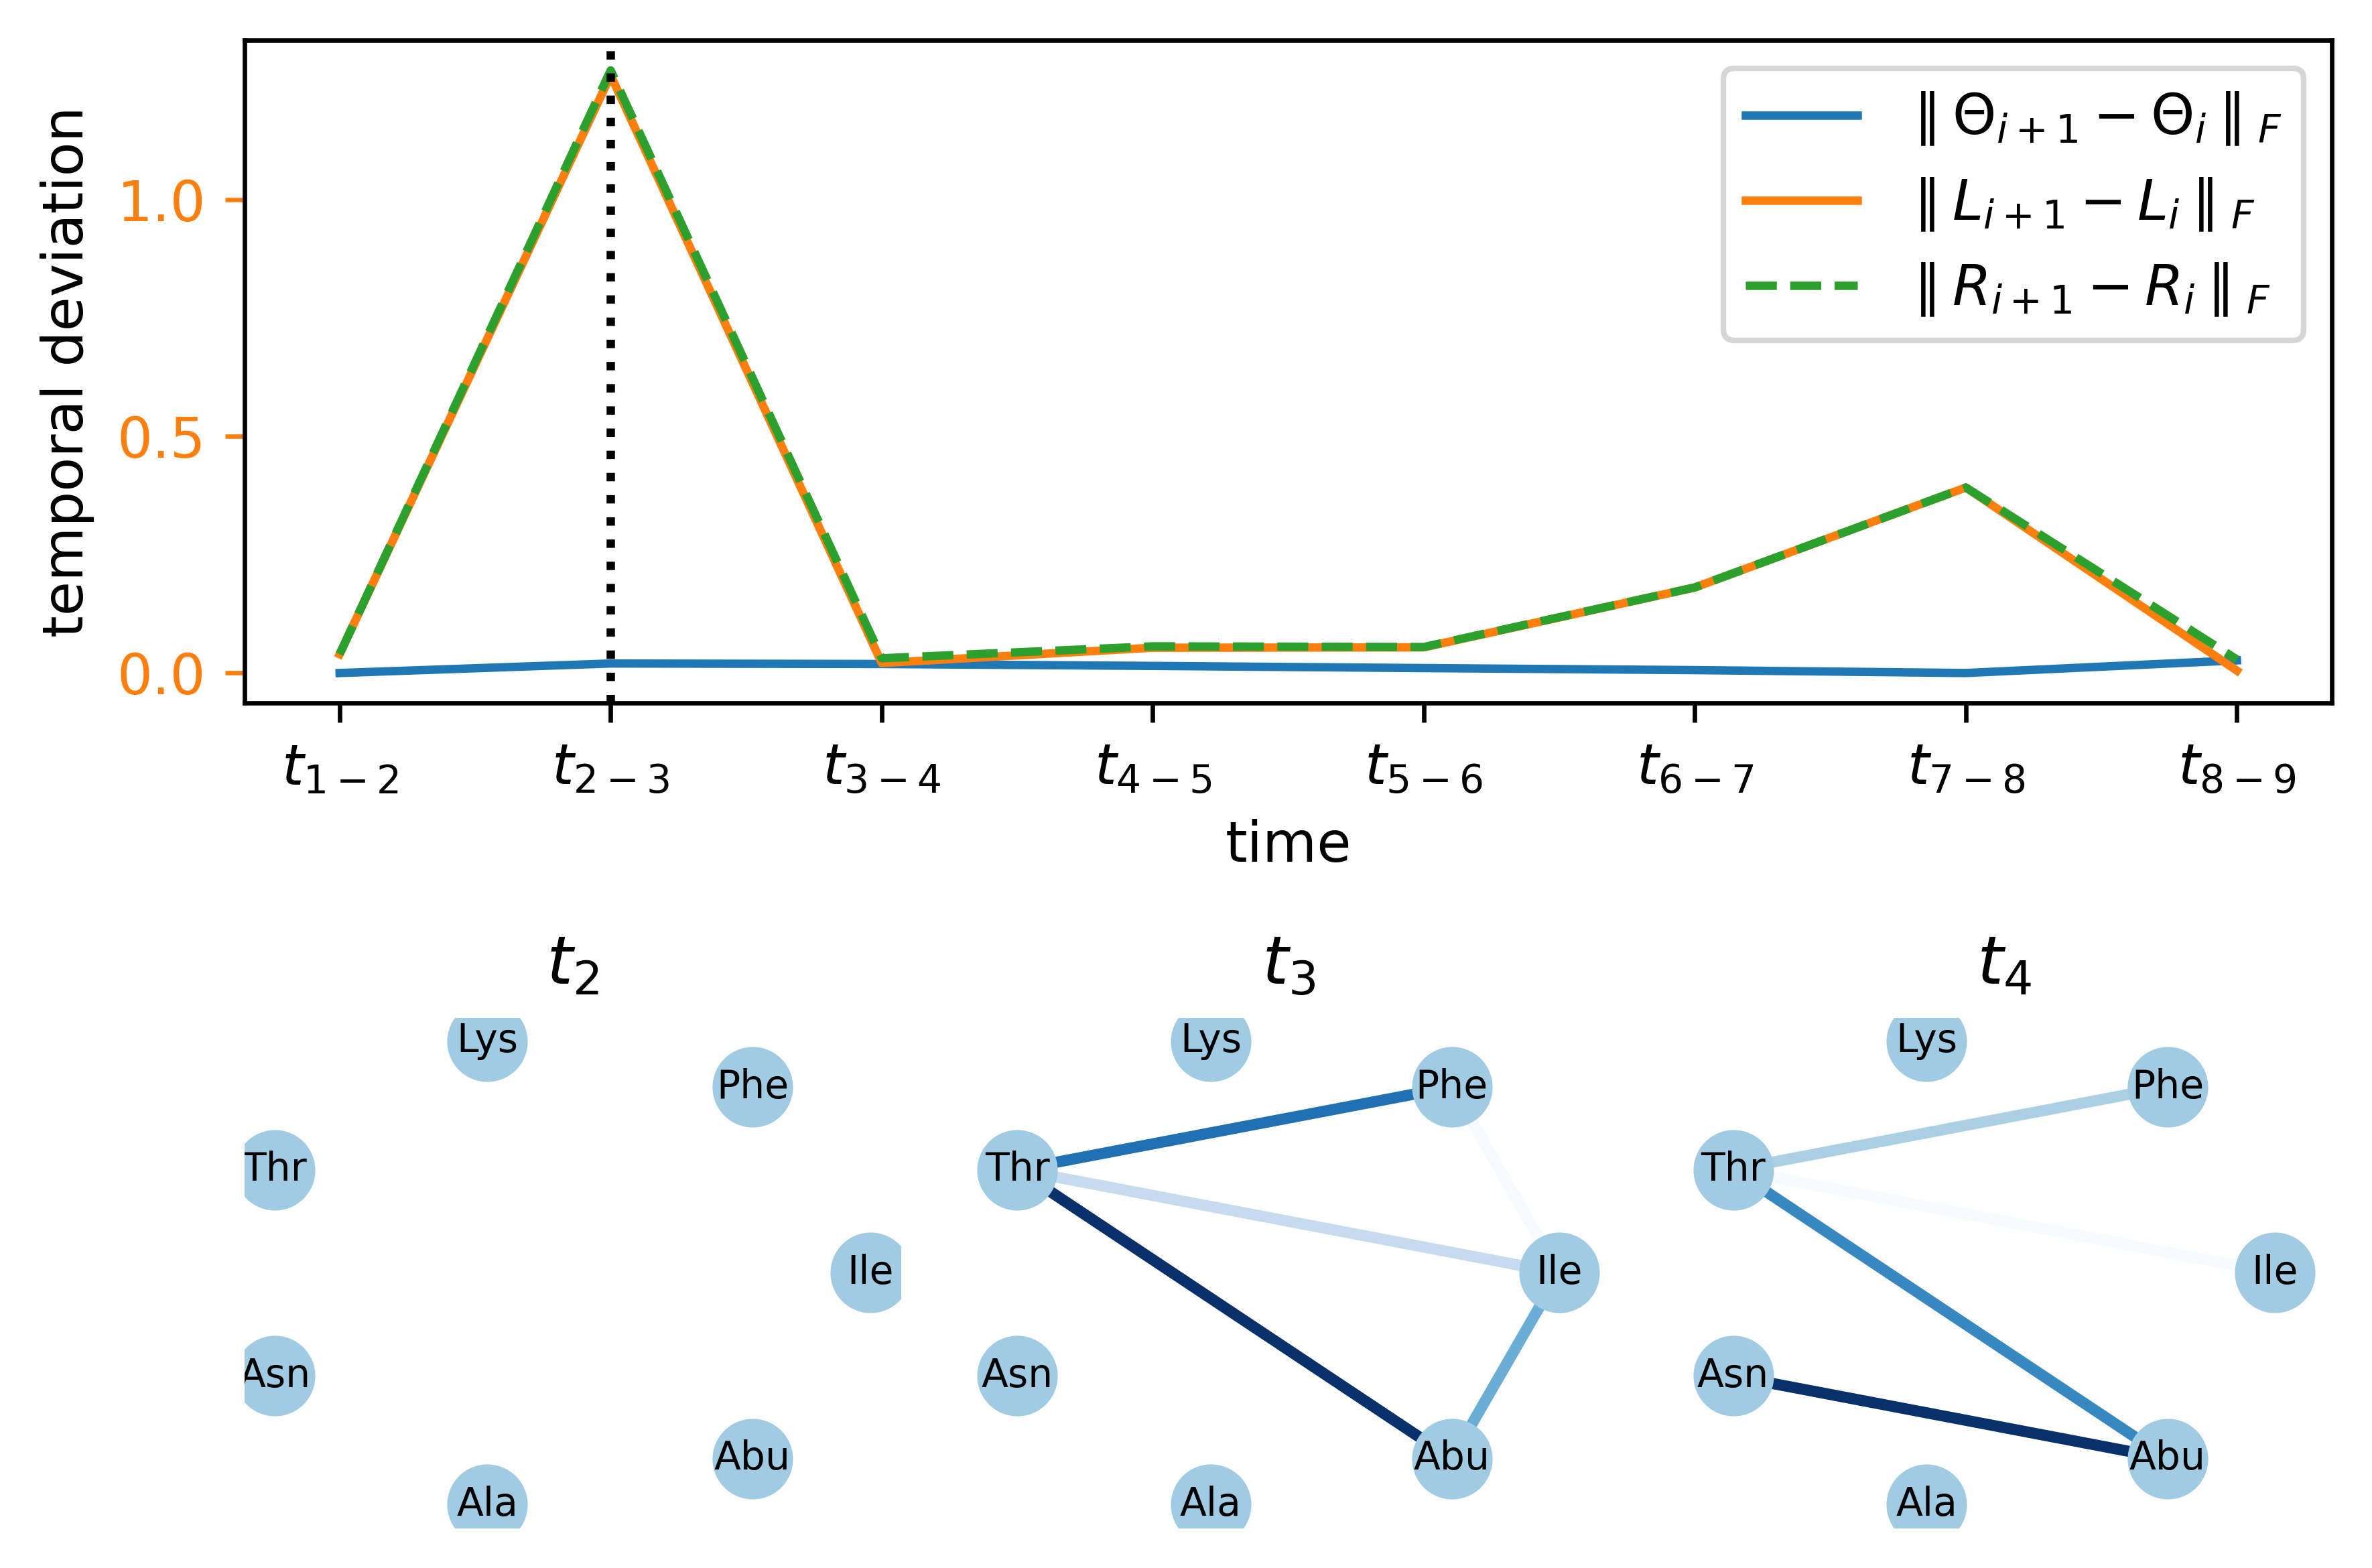

In [27]:
late = ll.latent_

precision_data = [np.linalg.norm(prec[i+1] - prec[i]) for i in range(prec.shape[0]-1)]
latent_data = [np.linalg.norm(late[i+1] - late[i]) for i in range(late.shape[0]-1)]
r_data = [np.linalg.norm((prec[i+1]- late[i+1]) - (prec[i] - late[i]) ) for i in range(late.shape[0]-1)]
timepoints = [r'$t_{%d - %d}$'%(i,i+1) for i in range(1, prec.shape[0])]

s1 = ax.plot(precision_data, label=r'$\parallel \Theta_{i+1} - \Theta_i\parallel_F$')
# ax.tick_params('y', colors='C0')
ax2 = ax#.twinx()
s2 = ax2.plot(latent_data, label=r'$\parallel L_{i+1} - L_i\parallel_F$', c='C1')
s3 = ax2.plot(r_data, label=r'$\parallel R_{i+1} - R_i\parallel_F$', ls='--', c='C2')
ax2.tick_params('y', colors='C1')

ax.axvline(1, ls=':', c='k')
ax.set_ylabel("temporal deviation");

ax.set_xlabel("time");
ax.set_xticks(np.arange(prec.shape[0]-1))

ax.set_xticklabels(timepoints)
ax.legend(s1+s2+s3,
           [r'$\parallel \Theta_{i+1} - \Theta_i\parallel_F$', r'$\parallel L_{i+1} - L_i\parallel_F$',
           r'$\parallel R_{i+1} - R_i\parallel_F$'],
           loc='upper right')

# ax.text(-1.5, 0.5, "(a)")
# ax.text(-1.5, -0.4, "(b)")


plot_func = partial(
    graph.plot_graph_with_latent_variables, labels=dict(zip(range(len(dims)), names)),
    node_size=180, font_size=7)


ax = f.add_subplot(gs[1,0])
plot_func(prec[1], len(dims), title=r'$t_%d$' % (2), ax=ax)

ax = f.add_subplot(gs[1,1])
plot_func(prec[2], len(dims), title=r'$t_%d$' % (3), ax=ax)

ax = f.add_subplot(gs[1,2])
plot_func(prec[3], len(dims), title=r'$t_%d$' % (4), ax=ax)

plt.tight_layout()
plt.show()

In [29]:
prec[2]

array([[ 0.        , -0.00305397, -0.        , -0.01276411, -0.        ,
        -0.        ,  0.00423717],
       [-0.00305397,  0.        , -0.        , -0.00054396, -0.        ,
        -0.        ,  0.        ],
       [-0.        , -0.        ,  0.        , -0.        , -0.        ,
        -0.        , -0.        ],
       [-0.01276411, -0.00054396, -0.        ,  0.        , -0.        ,
        -0.        ,  0.00333742],
       [-0.        , -0.        , -0.        , -0.        ,  0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
         0.        , -0.        ],
       [ 0.00423717,  0.        , -0.        ,  0.00333742, -0.        ,
        -0.        ,  0.        ]])